# I have clusters...what now?

## Cluster for exploration
> I cluster multiple variables in order to be able to explore and understand my data better. As an example:
> 1. cluster by bedrooms, bathrooms and square feet to understand the different groups of combinations.
> 2. plot 2 dimensions, such at logerror and lot size, and color by cluster id to see multiple dimensions in a single plot and understand the interaction of all these variables on your target, logerror in this case, a bit better. 
> 3. use the clusters to run an anova to see if there is a significant difference in the log error among these groups. 

## Cluster for labels
> I want to classify H-E-B customers by what they shop for. But I don't know what the distinct groups are yet. 
> 1. cluster based on something like average number of items per store department per visit. 
> 2. review clusters through exploration to create useful labels. 
> 3. use classification ML methods and a sample of the original data used to cluster to create a model for "predicting" those classes. 
> 4. after selecting the best model on train, test your model on the out-of-sample data that was already clustered (therefore it has labels) and evaluate. 
> 5. run the model on all data to add labels to all existing data. 
> 6. take some random samples to manually verify and do a little exploration to verify the new labels are doing what you expect. 

## Cluster for features

> Use clusters to create new, more descriptive features. Could also reduce number of dimensions. 
> 1. cluster by latitude, longitude and age to get "area clusters"
> 2. cluster by home and lot size to get "size clusters"
> 3. get descriptive stats of the value per sqft
> 4. somehow use a stat or 2 as a feature (or to create a feature). Standard deviation & median of the dollar per square foot for the cluster of the observation. 

## Acquire
SQL Query from zillow db
```sql
select 
	prop.parcelid
	, pred.logerror
	, pred.transactiondate
	, bathroomcnt
	, bedroomcnt
	, calculatedfinishedsquarefeet
	, fips
	, latitude
	, longitude
	, lotsizesquarefeet
	, regionidcity
	, regionidcounty
	, regionidneighborhood
	, regionidzip
	, yearbuilt
	, structuretaxvaluedollarcnt
	, taxvaluedollarcnt
	, landtaxvaluedollarcnt
	, taxamount
from properties_2017 prop
inner join predictions_2017 pred on prop.parcelid = pred.parcelid
where propertylandusetypeid = 261;
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# from env import get_url
df = pd.read_csv('../../../zillow/single_family.csv')

## Prepare

### Nulls
To keep this quick and simple, I will drop all nulls, either via rows or columns, dependent on the number missing for each variable. 

In [2]:
round(df.isna().sum()/len(df)*100,2)

parcelid                         0.00
logerror                         0.00
transactiondate                  0.00
bathroomcnt                      0.00
bedroomcnt                       0.00
calculatedfinishedsquarefeet     0.16
fips                             0.00
latitude                         0.00
longitude                        0.00
lotsizesquarefeet                0.70
regionidcity                     1.98
regionidcounty                   0.00
regionidneighborhood            63.71
regionidzip                      0.05
yearbuilt                        0.22
structuretaxvaluedollarcnt       0.16
taxvaluedollarcnt                0.00
landtaxvaluedollarcnt            0.00
taxamount                        0.01
dtype: float64

**Tasks**

1. Remove regionidneighborhood...33k missing values. 
2. Then delete all rows with any other missing values
3. Drop transactiondate, it can't be used in the model (it's "seeing into the future")

In [3]:
# drop regionidneighborhood and transactiondate
df = df.drop(columns=['regionidneighborhood', 'transactiondate'])

# drop all remaining rows with null values
df = df.dropna()

# df.info()

**Tasks**

1. Replace fips/county with the county name and create dummy vars for county, or split into 3 different dataframes. 
2. Create feature of age, which is 2017 - year built.
3. Compute tax rate and create a feature out of that so that we don't use clearly dependent variables: taxamount and the taxvaluedollarcnt fields (total, land & structure). We can then remove taxamount and taxvaluedollarcnt, and will keeps taxrate, structuretaxvaluedollarcnt, and landtaxvalue. 

**Later**

- Create new features out of bathroom, bedroom and square feet to separate the information contained in each of those.

### Features

**FIPS and County**

In [4]:
pd.crosstab(df.fips, df.regionidcounty)

regionidcounty,1286,2061,3101
fips,,,
6037,0,0,32855
6059,13708,0,0
6111,0,4350,0


FIPS:  

- 6037: Los Angeles County
- 6059: Orange County
- 6111: Ventura County

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697

In [5]:
# create dummy vars of fips id
county_df = pd.get_dummies(df.fips)
county_df

,6037,6059,6111
14,0,0,1
15,0,0,1
16,0,0,1
17,0,0,1
18,0,0,1
...,...,...,...
52437,1,0,0
52438,1,0,0
52439,1,0,0
52440,1,0,0


In [6]:
# rename columns to be the name of the county instead of the fips code
county_df.columns = ['LA', 'Orange', 'Ventura']

In [7]:
print(county_df.shape)
print(df.shape)

(50913, 3)
(50913, 17)


In [8]:
# concatenate the dataframe with the 3 county columns to the original dataframe
df = pd.concat([df, county_df], axis = 1)

# drop regionidcounty and fips columns
df = df.drop(columns = ['regionidcounty', 'fips'])

**Zip**

In [9]:
# df[df.LA == 1].regionidzip.value_counts()

**Age**

In [10]:
df['age'] = 2017 - df.yearbuilt

**Tax**

1. New feature: taxrate = taxamount / taxvaluedollarcnt 
2. Remove: taxamount, taxvaluedollarcnt
3. Keep: taxrate, landtaxvaluedollarcnt, structuretaxvaluedollarcnt

In [11]:
# create taxrate variable
df['taxrate'] = df.taxamount/df.taxvaluedollarcnt

df = df.drop(columns = ['taxamount', 'taxvaluedollarcnt', 'yearbuilt'])

In [12]:
# bin taxes
df['tax_bin'] = pd.cut(df.taxrate, bins = [0, .01, .011, .012, .013, .015, .02, .03, .05],
                      labels = [0, .01, .011, .012, .013, .015, .02, .03]
                     )

In [13]:
df.tax_bin.value_counts(sort = False)

0.000      687
0.010     5742
0.011    10910
0.012    16794
0.013     8444
0.015     6363
0.020     1692
0.030      199
Name: tax_bin, dtype: int64

**Lot Size**

1. convert to acres
2. bin

In [14]:
# create acres variable
df['acres'] = df.lotsizesquarefeet/43560

In [15]:
# bin acres
df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 200], 
                       labels = [0, .1, .15, .25, .5, 1, 5, 10, 20])

df.acres_bin.value_counts(sort=False)

0.00      5246
0.10     17455
0.15     20222
0.25      5516
0.50      1546
1.00       815
5.00        61
10.00       34
20.00       18
Name: acres_bin, dtype: int64

**Structure Size**

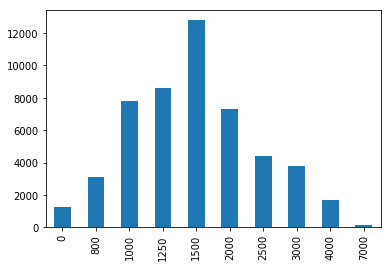

In [16]:
df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
                        bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                        labels = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000]
                       )

df.sqft_bin.value_counts(sort = False).plot.bar()

1. Remove extremes in bedrooms and baths, we will keeps homes with between 1 and 7 baths, between 0 and 7 bedrooms   
2. There is an error in zip, so we will remove those whose zips are invalid numbers (> 99999).   
3. remove square feet > 7000 for now
4. remove lot size (acres) > 10 for now
5. What is this tax rate of almost 50%?? Remove tax rate > 5% for now. 

In [17]:
# remove outliers in bed, bath, zip, & tax rate
df = df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
         (df.regionidzip < 100000) & 
         (df.bathroomcnt > 0) & 
         (df.bedroomcnt > 0) & 
         (df.acres < 10) &
         (df.calculatedfinishedsquarefeet < 7000) & 
         (df.taxrate < .05)
        )]

**Dollar/square foot**

In [18]:
df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

In [19]:
df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, bins = [0, 25, 50, 75, 100, 150, 200, 500, 1500],
                                         labels = [0, 25, 50, 75, 100, 150, 200, 500]
                                        )

In [20]:
df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 500, 1900],
                                   labels = [0, 1, 5, 20, 50, 100, 500]
                                  )

In [21]:
df['bed_bath_ratio'] = df.bedroomcnt/df.bathroomcnt

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50496 entries, 14 to 52441
Data columns (total 26 columns):
parcelid                        50496 non-null int64
logerror                        50496 non-null float64
bathroomcnt                     50496 non-null float64
bedroomcnt                      50496 non-null int64
calculatedfinishedsquarefeet    50496 non-null float64
latitude                        50496 non-null int64
longitude                       50496 non-null int64
lotsizesquarefeet               50496 non-null float64
regionidcity                    50496 non-null float64
regionidzip                     50496 non-null float64
structuretaxvaluedollarcnt      50496 non-null float64
landtaxvaluedollarcnt           50496 non-null float64
LA                              50496 non-null uint8
Orange                          50496 non-null uint8
Ventura                         50496 non-null uint8
age                             50496 non-null float64
taxrate                 

In [23]:
df = df.astype({'tax_bin': 'float64', 'sqft_bin': 'float64', 'acres_bin': 'float64', 
                'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})

**Cities**

I am thinking that LA is going to have the largest number of records as well as the widest range in values, so I want to add a boolean feature for city of LA. That will help the model for LA county. 

In [24]:
df[df.LA==1].regionidcity.value_counts()
# plt.hist(df[df.Orange==1].regionidcity.value_counts())
# plt.hist(df[df.Ventura==1].regionidcity.value_counts())


12447.0    11167
5534.0      1759
40227.0     1483
46298.0     1423
54311.0      817
           ...  
10815.0        1
41673.0        1
10608.0        1
44833.0        1
21395.0        1
Name: regionidcity, Length: 125, dtype: int64

So, 12447 is the ID for LA county. I confirmed through sampling and plotting, as well as looking up a few addresses.

In [25]:
df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)

For now, I will focus on the most difficult and diverse county, LA county. I'll add the others in after I see what I can find. 

I'll create an X dataframe in the following way: 

- I'm not sure where I will use bins and where I will use actual values, so for now I think i'll go with bins for tax only.  

- I'll go keep fields as is for: bedroomcnt, latitude, longitude, age, calculatedfinishedsquarefeet, acres, structure_dollar_per_sqft, land_dollar_per_sqft, bed_bath_ratio, cola.   

- I will remove parcelid, bathroomcnt, regionidcity, regionidzip, sqft_bin, acres_bin, landtaxvaluedollarcnt, taxrate, acres, structure_dollar_sqft_bin, lot_dollar_sqft_bin, LA, Orange, Ventura

I will create a dataframe with our `y` variable, `logerror`. 

In [26]:
X = df[df.LA == 1].drop(columns = ['parcelid', 'logerror', 'bathroomcnt', 'sqft_bin', 
                                   'lotsizesquarefeet', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 
                                   'landtaxvaluedollarcnt', 'taxrate', 'acres_bin', 'structure_dollar_sqft_bin', 
                                   'lot_dollar_sqft_bin', 'LA', 'Ventura', 'Orange']) 
y = df[df.LA == 1][['logerror']]

In [27]:
print(X.shape)
print(y.shape)

(32534, 11)
(32534, 1)


In [28]:
X.head()

,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,tax_bin,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
18545,4,2168.0,33980809,-117852570,30.0,0.020,0.146166,100.456181,18.283022,1.333333,0
18546,3,1893.0,33981576,-117852851,30.0,0.012,0.150390,109.154253,16.781865,1.000000,0
18547,3,1306.0,33977060,-117849219,30.0,0.011,0.100689,148.844564,82.168947,1.500000,0
18548,3,1306.0,33977024,-117850612,30.0,0.011,0.109986,87.136294,94.176581,1.500000,0
18549,3,1755.0,33978481,-117849983,30.0,0.011,0.109940,116.131624,82.835874,1.000000,0


In [29]:
y.head()

,logerror
18545,0.021416
18546,0.014245
18547,-0.006718
18548,0.004758
18549,-0.016153


## Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 447)

## Scale


In [31]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)

train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns.values).set_index([X_test.index.values])

train_scaled.head()

/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,tax_bin,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
31418,0.166667,0.186741,0.592407,0.541827,0.396947,0.400000,0.013457,0.039393,0.018985,0.142857,0.0
25233,0.333333,0.238548,0.339240,0.418606,0.435115,0.366667,0.013926,0.065176,0.060540,0.250000,0.0
24713,0.166667,0.198449,0.258553,0.467107,0.480916,0.433333,0.014594,0.058534,0.041985,0.142857,1.0
39840,0.333333,0.167569,0.395438,0.399014,0.496183,0.400000,0.013855,0.015691,0.004823,0.250000,0.0
22172,0.500000,0.239426,0.436532,0.857093,0.396947,0.500000,0.019935,0.033432,0.001621,0.357143,0.0


As I think about where it's difficult to predict housing prices, I think about areas where price and condition of homes vary drastically. This is generally in areas with older homes. So, how can we increase the information we have about those areas so that estimating the condition, and therefore the price, can be more accurate? There are so many ways to go about this, and who knows what will work best until we start trying them out. One idea I had was figure out a way to identify neighborhoods that are similar. Neighborhoods, in terms of the data available through the field `regionidneighborhood`, have many problems. The primary challenge is that so much of the data is missing. Secondly, there are many areas without defined neighborhoods. And the final point I'll mention (though there are more), is that there are so many neighborhoods that I wouldn't have to computing power to model each neighborhood separately! There is a way to do this, I'm sure, but that is going to wait until an iteration much in the future, and when it's possible to find the missing neighborhoods. 

So, all of that said, I want to find a way to cluster properties at a higher level than neighborhood and zip code in some cases, and can span both geographic areas. 

What if we could predict the error using the variance or standard deviation of the property assessed values of similar neighborhoods? Large standard deviation leads to larger errors. 
If we cluster by latitude, longitude and age maybe we can get city segments that were developed closer in time to one another, at a level higher than zip code and neighborhood. And maybe it will help separate terrain a bit, like coast vs mountains. We can then get basic statistics of dollar/sqft and lot/sqft of those areas and use those statistics as features. So we will use the clusters to extract statistics that describe them, and use those stats as features. 

I could also try clustering sizes. Acres, square feet, and location, e.g.

In [32]:
# train_scaled.head()

# X_train, train_scaled, X_test, test_scaled, y_train, y_test

In [ ]:
cluster_vars = train_scaled[['latitude', 'longitude', 'age']]

ks = range(2,20)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(cluster_vars)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

I'm going to go with more clusters beyond the elbow because I want to try for little more refinement than 4 different groups. We will see what happens with the count of records in each of those. 

We have a function later that is going to do the following 3 steps:

1. find the clusters
2. create df with cluster_id per index
3. count of observations per cluster id

In [ ]:
 # find clusters
kmeans = KMeans(n_clusters=10, random_state = 447)
train_cluster_array = kmeans.fit_predict(train_scaled[['longitude', 'latitude', 'age']])
test_cluster_array = kmeans.predict(test_scaled[['longitude', 'latitude', 'age']])    

train_cluster_array

In [ ]:
# create df of cluster id with each observation

train_clusters = pd.DataFrame(train_cluster_array, columns = ['area_cluster_id'], index = train_scaled.index)

test_clusters = pd.DataFrame(test_cluster_array, columns = ['area_cluster_id'], index = test_scaled.index)

train_clusters

In [ ]:
# output number of observations in each cluster
cluster_counts = train_clusters['area_cluster_id'].value_counts()
cluster_counts

In [33]:
def get_clusters_and_counts(k, var_list, cluster_col_name):
    """
    be sure your scaled X dataframes are named: train_scaled and test_scaled
    takes in k, list of vars to cluster on, and the new cluster id column name
    and returns the kmeans fitted object, dataframe of the train clusters with their observations, 
    test clusters and their observations, and a df of the number of observations per cluster on train. 
    """
    
    # find clusters
    kmeans = KMeans(n_clusters=k, random_state = 447)
    train_cluster_array = kmeans.fit_predict(train_scaled[var_list])
    test_cluster_array = kmeans.predict(test_scaled[var_list])
    
    # create df of cluster id with each observation
    train_clusters = pd.DataFrame(train_cluster_array, columns = [cluster_col_name], index = train_scaled.index)
    test_clusters = pd.DataFrame(test_cluster_array, columns = [cluster_col_name], index = test_scaled.index)
    
    # output number of observations in each cluster
    cluster_counts = train_clusters[cluster_col_name].value_counts()
    
    return kmeans, train_clusters, test_clusters, cluster_counts

In [34]:
def append_clusters_and_centroids(X_train, X_test, train_scaled, test_scaled, cluster_col_name, centroid_col_names_list):
    """
    be sure your dataframes are named: X_train, X_test, train_scaled, test_scaled (dataframes of X scaled)
    takes in list of vars to cluster on, 
    and the new cluster id column name
    and returns the kmeans fitted object, dataframe of the train clusters with their observations, 
    test clusters and their observations, and a df of the number of observations per cluster on train. 
    """

    # join the cluster ID's with the X dataframes (the scaled and unscaled, train and test
    
    X_train = pd.concat([X_train, train_clusters], axis = 1)
    train_scaled = pd.concat([train_scaled, train_clusters], axis = 1)

    X_test = pd.concat([X_test, test_clusters], axis = 1)
    test_scaled = pd.concat([test_scaled, test_clusters], axis = 1)
      
    # get the centroids for each distinct cluster...
    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=centroid_col_names_list).reset_index()
    centroids.rename(columns = {'index': cluster_col_name}, inplace = True)
    
    # merge the centroids with the X dataframes (both the scaled and unscaled)
    X_train = pd.merge(X_train, centroids, how = 'left', on = cluster_col_name)
    train_scaled = pd.merge(train_scaled, centroids, how = 'left', on = cluster_col_name)

    X_test = pd.merge(X_test, centroids, how = 'left', on = cluster_col_name)
    test_scaled = pd.merge(test_scaled, centroids, how = 'left', on = cluster_col_name)

    return X_train, train_scaled, X_test, test_scaled, centroids

In [35]:
# set vars for functions
cluster_vars = ['longitude', 'latitude', 'age']
cluster_col_name = 'area_cluster_id'
centroid_col_names = ['centroid_' + i for i in cluster_vars]

# run kmeans, get clusters and counts per cluster
kmeans, train_clusters, test_clusters, cluster_counts = get_clusters_and_counts(k = 10, 
                                                                                var_list = cluster_vars, 
                                                                                cluster_col_name = cluster_col_name)

# print(cluster_counts)

In [36]:
# append cluster id with centroid to our X dataframes (scaled and original, train and test)
X_train, train_scaled, X_test, test_scaled, area_centroids = append_clusters_and_centroids(
    X_train = X_train, X_test = X_test, train_scaled = train_scaled, test_scaled = test_scaled,
    cluster_col_name = cluster_col_name, centroid_col_names_list = centroid_col_names)

In [37]:
X_train.columns

Index(['bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'age', 'tax_bin', 'acres', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'bed_bath_ratio', 'cola', 'area_cluster_id',
       'centroid_longitude', 'centroid_latitude', 'centroid_age'],
      dtype='object')

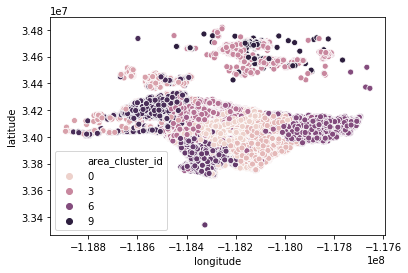

In [39]:
sns.scatterplot(X_train.longitude, X_train.latitude, hue = X_train.area_cluster_id)

Now, I'd like to cluster by size. Then I will group by the two different cluster types (area/age & size) and compute summary statistics. 

     k         sse
0    2  157.766628
1    3   96.074238
2    4   69.015177
3    5   54.652253
4    6   40.979697
5    7   33.454291
6    8   28.269425
7    9   24.096930
8   10   20.868484
9   11   18.660949
10  12   16.876623
11  13   15.393998
12  14   14.213528
13  15   13.257621
14  16   12.393219
15  17   11.549011
16  18   10.788903
17  19   10.037317


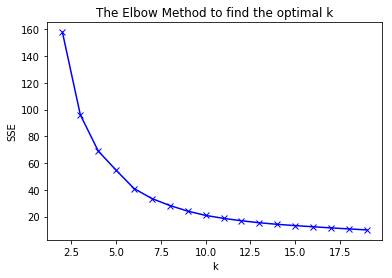

In [41]:
cluster_vars = train_scaled[['calculatedfinishedsquarefeet', 'acres']]

ks = range(2,20)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(cluster_vars)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)
    
print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [42]:
# set vars
cluster_vars = ['calculatedfinishedsquarefeet', 'acres']
cluster_col_name = 'size_cluster_id'

# run kmeans, get clusters and counts per cluster
for k in range(3,9):
    kmeans = KMeans(n_clusters=k, random_state = 447)
    train_cluster_array = kmeans.fit_predict(train_scaled[cluster_vars])
    
    # create df of cluster id with each observation
    train_clusters = pd.DataFrame(train_cluster_array, columns = [cluster_col_name], index = train_scaled.index)
    
    # output number of observations in each cluster
    cluster_counts = train_clusters[cluster_col_name].value_counts()
    
    print(cluster_counts)

0    14457
1     6728
2     1588
Name: size_cluster_id, dtype: int64
0    10571
1     7852
3     3500
2      850
Name: size_cluster_id, dtype: int64
3    8107
0    8074
4    4242
2    1865
1     485
Name: size_cluster_id, dtype: int64
4    8079
1    8040
5    4202
0    1842
3     482
2     128
Name: size_cluster_id, dtype: int64
2    7398
3    6358
0    4579
5    2698
4    1244
1     376
6     120
Name: size_cluster_id, dtype: int64
0    7001
6    5566
3    4639
1    2878
5    1578
2     737
7     245
4     129
Name: size_cluster_id, dtype: int64


In [43]:
# set vars for functions
cluster_vars = ['calculatedfinishedsquarefeet', 'acres']
cluster_col_name = 'size_cluster_id'
centroid_col_names = ['centroid_' + i for i in cluster_vars]

# run kmeans, get clusters and counts per cluster
kmeans, train_clusters, test_clusters, cluster_counts = get_clusters_and_counts(k = 5, 
                                                                                var_list = cluster_vars, 
                                                                                cluster_col_name = cluster_col_name)

# append cluster id with centroid to our X dataframes (scaled and original, train and test)
X_train, train_scaled, X_test, test_scaled, size_centroids = append_clusters_and_centroids(
    X_train = X_train, X_test = X_test, train_scaled = train_scaled, test_scaled = test_scaled,
    cluster_col_name = cluster_col_name, centroid_col_names_list = centroid_col_names)

In [44]:
X_train.head()

,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,tax_bin,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola,area_cluster_id,centroid_longitude,centroid_latitude,centroid_age,size_cluster_id,centroid_calculatedfinishedsquarefeet,centroid_acres
0,2,1428.0,34216379,-118221536,53.0,0.012,0.155051,57.044118,31.889399,1.0,0,4,0.424876,0.544239,0.530352,0,0.213420,0.017530
1,3,1782.0,33842219,-118374196,58.0,0.011,0.159734,94.276094,101.609658,1.5,0,7,0.456173,0.354196,0.474303,0,0.213420,0.017530
2,2,1508.0,33722971,-118314108,64.0,0.013,0.166391,84.685676,70.478201,1.0,1,7,0.456173,0.354196,0.474303,0,0.213420,0.017530
3,3,1297.0,33925275,-118398469,66.0,0.012,0.159022,22.817271,8.128627,1.5,0,7,0.456173,0.354196,0.474303,3,0.133982,0.014076
4,4,1788.0,33986008,-117830950,53.0,0.015,0.219651,48.435682,2.756062,2.0,0,6,0.827730,0.490073,0.394873,0,0.213420,0.017530


In [ ]:
# plt.scatter(X_train.acres, X_train.calculatedfinishedsquarefeet, c = X_train.size_cluster_id)

In [ ]:
# plt.scatter(X_train.longitude, X_train.latitude, c = X_train.area_cluster_id)

Use the 2 cluster types and compute some stats. These could be our features. 

In [45]:
X_train.groupby(['area_cluster_id', 'size_cluster_id'])['structure_dollar_per_sqft'].describe()

count        mean         std        min  \
area_cluster_id size_cluster_id                                              
0               0                 884.0   79.671338   77.652727   3.900378   
                1                  44.0  139.183188  104.566314   8.898533   
                2                 168.0  116.895546   76.442390   0.332569   
                3                1765.0   75.934121   64.124725   1.284497   
                4                 388.0   96.093102   76.831777   0.442845   
1               0                1545.0   74.376512   39.515401  10.710072   
                1                   9.0  167.974817   69.732503  47.513524   
                2                 120.0  107.787706   52.232934  23.580215   
                3                2032.0   73.774079   45.102640   1.315436   
                4                 479.0   86.001665   49.300900  14.503001   
2               0                 273.0  110.846255   38.678366  31.807816   
                1                 120.0  185.120747  104.142271  67.848157   
                2                 276.0  135.652290   65.066833  47.906809   
                3                  91.0  129.764516   48.949868  42.339474   
                4                 362.0  114.280371   37.353593  23.491012   
3               0                 768.0   83.457768   21.888268  14.905842   
                1                  15.0  101.653449   22.992831  59.812005   
                2                 229.0   80.358709   21.642102  19.354621   
                3                 273.0   85.790562   26.223586  25.684303   
                4                 564.0   81.752141   24.848055   6.768705   
4               0                1024.0   91.820276   61.131294  12.983811   
                1                  62.0  183.376222  134.766544  18.499126   
                2                 234.0  150.505970  117.520991  18.856574   
                3                 976.0   90.667520   80.727629   1.145780   
                4                 527.0  114.806548   73.965277  18.333180   
5               0                 194.0  109.636202   64.195094  28.440223   
                1                 116.0  213.494561  109.777656  47.326077   
                2                 280.0  169.189174   86.256440  33.499849   
                3                  65.0  111.723904  105.594386  30.784874   
                4                 234.0  124.317005   66.891169  28.795547   
6               0                1040.0   78.165215   32.534308   7.138599   
                1                  44.0  138.150687   47.814075  19.163488   
                2                 153.0  111.489040   40.321798  33.138035   
                3                 826.0   73.148584   35.314749   6.466063   
                4                 562.0   91.371467   35.543597  20.428708   
7               0                 954.0   74.739551   63.355885   0.158281   
                1                  13.0  158.830056   57.358582  21.054772   
                2                 123.0  110.488136   64.187936  17.589542   
                3                1077.0   78.831164   70.598115   3.461107   
                4                 383.0   83.338417   48.284346  16.161382   
8               0                1185.0   83.041893   46.140521   1.676048   
                1                  61.0  170.455694  113.454701  37.506792   
                2                 277.0  128.375482  102.057028  29.853751   
                3                 671.0   88.967921   78.564237  10.053846   
                4                 699.0   96.758507   79.750714  14.677566   
9               0                 207.0   64.130803   26.700382  18.426781   
                1                   1.0   38.001147         NaN  38.001147   
                2                   5.0   48.765896    8.752808  38.625359   
                3                 331.0   66.767922   25.665596  11.957597   
                4                  44.0   69.351312   21

In [46]:
# get summary stats of the dollar per sqft to possibly use one/some of these as new variables
cluster_stats = X_train.groupby(['area_cluster_id', 'size_cluster_id'])['structure_dollar_per_sqft'].describe().reset_index()
scaled_cluster_stats = train_scaled.groupby(['area_cluster_id', 'size_cluster_id'])['structure_dollar_per_sqft'].describe().reset_index()

cluster_stats

,area_cluster_id,size_cluster_id,count,mean,std,min,25%,50%,75%,max
0,0,0,884.0,79.671338,77.652727,3.900378,35.729544,66.907925,101.704008,1188.260300
1,0,1,44.0,139.183188,104.566314,8.898533,63.303912,113.342377,211.797310,451.919614
2,0,2,168.0,116.895546,76.442390,0.332569,55.887795,103.925501,157.944673,355.406141
3,0,3,1765.0,75.934121,64.124725,1.284497,35.745006,65.216458,100.717428,1083.118971
4,0,4,388.0,96.093102,76.831777,0.442845,45.414474,77.864939,125.943600,791.103896
5,1,0,1545.0,74.376512,39.515401,10.710072,41.666232,71.961982,95.051663,591.204037
6,1,1,9.0,167.974817,69.732503,47.513524,124.945199,139.344597,234.551510,246.260092
7,1,2,120.0,107.787706,52.232934,23.580215,74.592445,102.063580,131.558915,313.444414
8,1,3,2032.0,73.774079,45.102640,1.315436,42.429156,72.935538,93.927906,927.552987
9,1,4,479.0,86.001665,49.300900,14.503001,47.957702,81.165845,108.627705,430.374470


In [ ]:
scaled_cluster_stats

Use the median and standard deviation for each of these as variables. 

In [47]:
cluster_stats = cluster_stats[['area_cluster_id', 'size_cluster_id', 'std', '50%']]
scaled_cluster_stats = scaled_cluster_stats[['area_cluster_id', 'size_cluster_id', 'std', '50%']]

Null values will occur when there is only 1 record for the clusters. Fill null values with the median. 
Add to dataframe (non-scaled and scaled)

In [48]:
X_train = X_train.merge(cluster_stats, how='left', on=['area_cluster_id', 'size_cluster_id'])
train_scaled = train_scaled.merge(scaled_cluster_stats, how='left', on=['area_cluster_id', 'size_cluster_id'])

X_test = X_test.merge(cluster_stats, how='left', on=['area_cluster_id', 'size_cluster_id'])
test_scaled = test_scaled.merge(scaled_cluster_stats, how='left', on=['area_cluster_id', 'size_cluster_id'])

In [49]:
print(X_train.shape)
print(X_test.shape)
print(train_scaled.shape)
print(test_scaled.shape)

(22773, 20)
(9761, 20)
(22773, 20)
(9761, 20)


At this point, here is what I would do to solidify features and move on:

1. I might try to use the difference of structure_dollar_per_sqft for the observation from the median as a feature  
2. Keep the standard deviation as a feature. 
3. Remove latitude, longitude, area_cluster_id, size_cluster_id, centroid_*, 
4. Try to model with and without each of the following features: age, calculatedfinishedsquarefeet (they were used in the clustering, and maybe information needed has been captured). 

In [50]:
X_train.head()

,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,tax_bin,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola,area_cluster_id,centroid_longitude,centroid_latitude,centroid_age,size_cluster_id,centroid_calculatedfinishedsquarefeet,centroid_acres,std,50%
0,2,1428.0,34216379,-118221536,53.0,0.012,0.155051,57.044118,31.889399,1.0,0,4,0.424876,0.544239,0.530352,0,0.213420,0.017530,61.131294,84.860733
1,3,1782.0,33842219,-118374196,58.0,0.011,0.159734,94.276094,101.609658,1.5,0,7,0.456173,0.354196,0.474303,0,0.213420,0.017530,63.355885,66.806492
2,2,1508.0,33722971,-118314108,64.0,0.013,0.166391,84.685676,70.478201,1.0,1,7,0.456173,0.354196,0.474303,0,0.213420,0.017530,63.355885,66.806492
3,3,1297.0,33925275,-118398469,66.0,0.012,0.159022,22.817271,8.128627,1.5,0,7,0.456173,0.354196,0.474303,3,0.133982,0.014076,70.598115,69.463542
4,4,1788.0,33986008,-117830950,53.0,0.015,0.219651,48.435682,2.756062,2.0,0,6,0.827730,0.490073,0.394873,0,0.213420,0.017530,32.534308,78.289303


In [51]:
X_train['dollar_sqft_diff'] = X_train.structure_dollar_per_sqft - X_train['50%']

cols_to_drop = ['latitude', 'longitude', 'area_cluster_id', 'centroid_longitude', 'centroid_latitude', 
                'centroid_age', 'size_cluster_id', 'centroid_calculatedfinishedsquarefeet', 'centroid_acres',
                'structure_dollar_per_sqft', '50%'
               ]

X_train.drop(columns = cols_to_drop, inplace = True)

In [52]:
X_train.head()

,bedroomcnt,calculatedfinishedsquarefeet,age,tax_bin,acres,land_dollar_per_sqft,bed_bath_ratio,cola,std,dollar_sqft_diff
0,2,1428.0,53.0,0.012,0.155051,31.889399,1.0,0,61.131294,-27.816615
1,3,1782.0,58.0,0.011,0.159734,101.609658,1.5,0,63.355885,27.469602
2,2,1508.0,64.0,0.013,0.166391,70.478201,1.0,1,63.355885,17.879184
3,3,1297.0,66.0,0.012,0.159022,8.128627,1.5,0,70.598115,-46.646271
4,4,1788.0,53.0,0.015,0.219651,2.756062,2.0,0,32.534308,-29.853621


- find out why index was dropped
- drop nan in std